In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("true.csv")
df.drop(columns=["date","title"],inplace=True)

In [3]:
df

,text,subject
0,WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews


In [4]:
df['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df['text'], df['subject'], test_size=0.2, random_state=42)

In [6]:
from collections import Counter

# Join all text entries in the 'text' column into one big string, then split into words
all_words = " ".join(df['text']).split()

# Count the frequency of each unique word in the dataset
word_freq = Counter(all_words)

# Print the number of unique words (the vocabulary size)
print(len(word_freq))


178503


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(xtrain)

xtrain_tokenized = tokenizer.texts_to_sequences(xtrain)
xtest_tokenized = tokenizer.texts_to_sequences(xtest)

xtrain_padded = pad_sequences(xtrain_tokenized, maxlen=400, padding="post", truncating="post")
xtest_padded = pad_sequences(xtest_tokenized, maxlen=400, padding="post", truncating="post")

#saving tokenizer for deployment 
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ytrain_encoded = le.fit_transform(ytrain)
ytest_encoded = le.transform(ytest)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model=Sequential()
model.add(Embedding(input_dim=50000,output_dim=128,input_length=400))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\Fady Ramy\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
history=model.fit(xtrain_padded,ytrain_encoded,epochs=10,validation_data=(xtest_padded,ytest_encoded))

Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.8325 - loss: 0.3559 - val_accuracy: 0.8814 - val_loss: 0.3149
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 144s 269ms/step - accuracy: 0.8555 - loss: 0.3361 - val_accuracy: 0.9225 - val_loss: 0.3002
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 107s 201ms/step - accuracy: 0.8042 - loss: 0.4059 - val_accuracy: 0.7799 - val_loss: 0.4428
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 95s 178ms/step - accuracy: 0.9005 - loss: 0.2601 - val_accuracy: 0.9788 - val_loss: 0.0821
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 125s 234ms/step - accuracy: 0.9859 - loss: 0.0494 - val_accuracy: 0.9841 - val_loss: 0.0575
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 107s 200ms/step - accuracy: 0.9945 - loss: 0.0231 - val_accuracy: 0.9895 - val_loss: 0.0428
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 117s 219ms/step - accuracy: 0.9968 - loss: 0.0131 - val_accuracy: 0.9879 - val_loss: 0.0516
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 118s 219ms/step - accuracy: 0.9977 - 

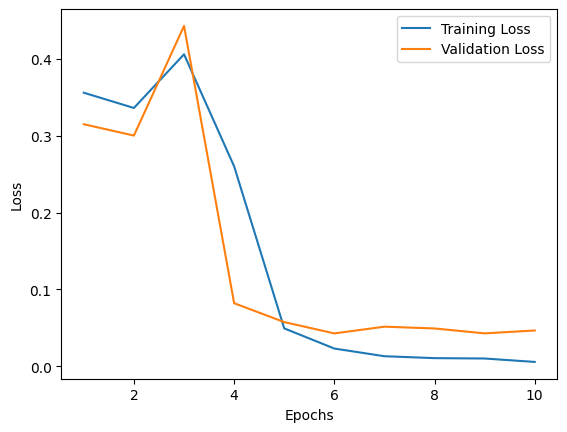

In [11]:
from matplotlib import pyplot as plt
epochs=len(history.history['loss'])
plt.plot(range(1,epochs+1),history.history['loss'],label='Training Loss')
plt.plot(range(1,epochs+1),history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

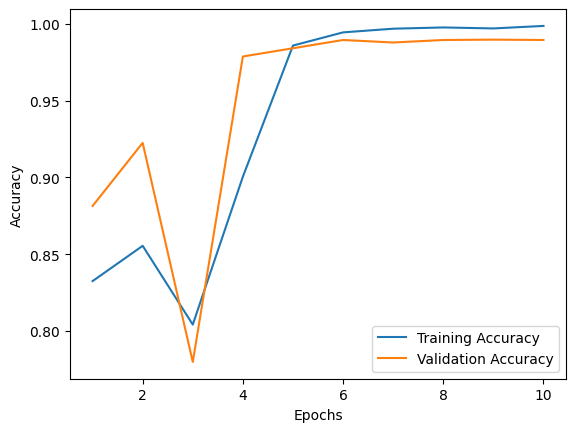

In [12]:
from matplotlib import pyplot as plt
epochs=len(history.history['loss'])
plt.plot(range(1,epochs+1),history.history['accuracy'],label='Training Accuracy')
plt.plot(range(1,epochs+1),history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(xtest_padded)
y_pred_classes = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(ytest_encoded, y_pred_classes)
print("Accuracy:", accuracy)

134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step
Accuracy: 0.9894957983193278


In [14]:
print(classification_report(ytest_encoded, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2256
           1       0.98      1.00      0.99      2028

    accuracy                           0.99      4284
   macro avg       0.99      0.99      0.99      4284
weighted avg       0.99      0.99      0.99      4284



In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

def predict_subject(text):
    text_tokenized = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_tokenized, maxlen=400, padding="post", truncating="post")
    prediction = model.predict(text_padded)

    # Convert probability to class label (0 or 1)
    predicted_class = (prediction > 0.5).astype(int)

    # Inverse transform the class label to the original subject string
    predicted_label = le.inverse_transform(predicted_class)

    return predicted_label[0]

In [16]:
print(predict_subject("WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€œfiscal conservativeâ€ on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€œFace the Nation,â€ drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense â€œdiscretionaryâ€ spending on programs that support education, scientific research, infrastructure, public health and environmental protection. â€œThe (Trump) administration has already been willing to say: â€˜Weâ€™re going to increase non-defense discretionary spending ... by about 7 percent,â€™â€ Meadows, chairman of the small but influential House Freedom Caucus, said on the program. â€œNow, Democrats are saying thatâ€™s not enough, we need to ..."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
politicsNews


c:\Users\Fady Ramy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# Add labels
df_fake['label'] = 0
df_true['label'] = 1

# Combine datasets
df = pd.concat([df_fake, df_true])

# Extract features and labels
X = df['text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.save("lstm_model.h5")